<a href="https://colab.research.google.com/github/karamazovjk/ufabc-projects/blob/main/C%C3%B3pia_de_2_motor_imagery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **2 Processamento de dados para BCI de imagética motora**

##**2.1 Ritmo sensório-motor**

###**Ritmos sensório-motores (SMRs, do inglês sensorimotor rhythms):** são alterações rítmicas nas faixas alfa e beta que se manifestam como uma dessincronização relacionada a evento (ERD, do inglês event-related desynchronization) seguida de uma sincronização relacionada a evento (ERS, do inglês event-related synchronization) – perceptíveis no sinal de EEG, respectivamente, por uma diminuição relativa e por um aumento relativo na potência do sinal, em comparação com os registros de instantes anteriores ao início da tarefa.



###**Figura 2.1:** Exemplo de ERD e ERS.

<center><img src="https://drive.google.com/uc?id=17q3MfKhriv9pOzUYNzULImdFU1Fx33UV" class="centerImage"></center>

###**Distribuição espacial do SMR:** embora também varie de indivíduo para indivíduo, essas alterações rítmicas nas faixas alfa e beta se manifestam nos eletrodos centrais, como C3 e C4, por exemplo, em resposta a estratégias de imagética motora.

###**Imagética motora:** embora a ERD e a ERS sejam manifestações predominantemente associadas ao planejamento e a efetivação do movimento, a imagética motora, depois de algum treino, produz uma reação similar. Dessa forma, mesmo que com uma intensidade menor se comparada àquela relacionada ao movimento efetivo, a ERD e a ERS dessa imagética são detectáveis e por isso utilizadas em experimentos de BCI.

###**SMR como marcador de BCI:** são marcadores de BCI porque são detectáveis a partir da análise do conteúdo espectral nas faixas alfa e beta do sinal EEG dos eletrodos centrais associados a imagética motora.

###**Protocolo experimental:** uma BCI de SMR baseada na imagética motora das mãos direita e esquerda, por exemplo, apresenta o seguinte protocolo experimental: acomodado em uma cadeira confortável, e diante de um monitor que serve como campo de iteração, um usuário realiza várias sessões de aquisição durante as quais ora ele imagina a mão direita e ora a mão esquerda; a imagética motora é guiada por indicações dadas no monitor; cada sessão em geral dura de 5 a 10 e inicia com um sinal de atenção, para que o usuário se concentre; depois, segue com um sinal de execução, para que ele imagine por alguns segundos o movimento da mão direita ou o da mão esquerda. Nesse ínterim, o monitor devolve um sinal de realimentação, para que o usuário reforce seu controle volitivo. Um ensaio experimental completo totaliza de 40 a 80 sessões, em ordem aleatória, para cada tipo de imagética.

###**Figura 2.2:** Exemplo de um sessão para gerar SMR.

<center><img src="https://drive.google.com/uc?id=1Or4R7t-pB5GIquUOzoNRn-E-mWLmHqN-" class="centerImage"></center>

###**Reabilitação motora:** como as BCI de SMR estimulam as áreas motoras, elas são utilizadas para testar protocolos de reabilitação de pessoas com quadro de acidente vascular cerebral.

##**2.2 Pré-processamento e extração de SMR**

### **Base de dados ([10.1038/s41597-025-04826-y](https://www.nature.com/articles/s41597-025-04826-y)):** *A multi-day and high-quality EEG dataset for motor imagery brain-computer interface*

In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

In [2]:
from matplotlib.patches import Rectangle
from scipy.io import loadmat
from scipy.fft import fft
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn import svm
from keras.models import Sequential
from keras.layers import Conv2D, DepthwiseConv2D, SeparableConv2D
from keras.layers import AveragePooling2D, Dropout, Flatten, Dense
from keras.layers import Input, BatchNormalization, Activation
from keras.constraints import max_norm
from keras.utils import to_categorical

In [3]:
def download_data(id):
  prefix ='https://drive.google.com/drive/folders/'
  suffix = '?usp=drive_link'
  url = prefix + id + suffix
  piperun('gdown --folder {}'.format(url))

def piperun(cmd):
  fp = os.popen(cmd)
  res = fp.read()
  print(res, end='')
  fp.close()

In [4]:
download_data(id='146NTQ7k5zEJrWepp7g7FAO64lZAJd9a4')

Processing file 19BTrWRffT5FrjwGFH05asJMQiB90o4WL sub-001_ses-01_task-motorimagery_eeg.mat
Processing file 1zXv2BaI2c_7RCCbZ-MTCg0iuxof6EtPw sub-002_ses-01_task-motorimagery_eeg.mat
Processing file 1P0AIK08DzVrskSwpBRCQGfF3SLCdZ9SI sub-003_ses-01_task-motorimagery_eeg.mat
Processing file 1IYotSnktKo933JwwWek-Adr1ZKeDdRzk sub-004_ses-01_task-motorimagery_eeg.mat
Processing file 13wev4m1m7aUv7HrMVlaz-P58ATSBUPnH sub-005_ses-01_task-motorimagery_eeg.mat
Processing file 1klUAbyub24R3YqLLfwVpOPdFTBWSPrl9 sub-006_ses-01_task-motorimagery_eeg.mat
Processing file 16bYKCgykeAXfUAb1tJVvd1fK_2O8DJfk sub-007_ses-01_task-motorimagery_eeg.mat
Processing file 1VtP1NmHxoQxMI-8kQXy2asKH1DUAcHOI sub-008_ses-01_task-motorimagery_eeg.mat
Processing file 1JSwUK2Cq3lOEUtqR8tVQO_fmbhs2meKn sub-009_ses-01_task-motorimagery_eeg.mat
Processing file 1qHUovCbKpyaAtp81iX56s5pWmUzm5U2U sub-010_ses-01_task-motorimagery_eeg.mat
Processing file 1kV67xiK3Nf8-K7j2KlS7QNamQhXmjKzo task-motorimagery_channels.tsv


In [5]:
def load_data(dir):
  file_list = [files for _, _, files in os.walk(dir)][0]
  file_list.sort()
  flag = 0
  s_data = []
  for file in file_list:
    if file.split('.')[-1] == 'tsv':
      open_file = pd.read_csv(os.path.join(dir, file), sep='\t')
      channels = list(open_file['name'])
      channels.remove('Pz')
    else:
      open_file = loadmat(os.path.join(dir, file))
      data = open_file['data']
      labels = open_file['labels']
      N = len(data.shape)
      exp_data = np.expand_dims(arrange_data(data, labels), N+1)
      s_data = concat(s_data, exp_data, N + 1, flag)
      flag = 1
  return channels, np.swapaxes(np.swapaxes(s_data, 0, 1), 2, 3)

def arrange_data(data, labels):
  N = len(data.shape)
  l_flag, r_flag = 0, 0
  left_data, right_data = [], []
  for i in range(labels.shape[1]):
    exp_data = np.expand_dims(data[:, :, i], N - 1)
    if labels[0, i] == 1:
      left_data = concat(left_data, exp_data, N - 1, l_flag)
      l_flag = 1
    else:
      right_data = concat(right_data, exp_data, N - 1, r_flag)
      r_flag = 1
  exp_left_data = np.expand_dims(left_data, N)
  exp_right_data = np.expand_dims(right_data, N)
  return np.concatenate((exp_left_data, exp_right_data), N)

def concat(n_data, data, N, flag):
  return data if flag == 0 else np.concatenate((n_data, data), N)

In [6]:
channels, data = load_data(dir='/content/motor_imagery')
data.shape

(1000, 58, 2, 100, 10)

In [7]:
def plot_eeg_time(data, Fs, elect):
  N = data.shape[0]
  Ne = len(elect)
  t = np.arange(0, N / Fs, 1 / Fs)
  x, y = np.arange(0, (N / Fs) + 1, 1.0), [-15, 0, 15]
  xticks, yticks = x, y
  xlim, ylim = [0, N / Fs], [-30, 30]
  xlabel, ylabel = '$\\text{Tempo }(s)$', '$\\text{Tensão }(\\mu V)$'
  axcolor = 'dimgrey'
  plt.rcParams['font.size'] = 12
  plt.rcParams['mathtext.fontset'] = 'cm'
  fig = plt.figure(figsize=(7, 1.5 * Ne))
  gs = fig.add_gridspec(Ne, 1, hspace=0.1)
  axs = gs.subplots()
  for n, ax in enumerate(axs):
    if n != Ne - 1:
      set_axis(x, y, [], yticks, ax, xlim, ylim)
    else:
      set_axis(x, y, xticks, yticks, ax, xlim, ylim)
      ax.set_xlabel(xlabel, color=axcolor, labelpad=1)
    ax.set_ylabel(ylabel, color=axcolor, labelpad=1)
    ax.hlines(0, 0, 4, color=axcolor, linestyles='--', linewidth=0.6)
    ax.plot(t, data[:, n], color='tab:blue', linewidth=2)
    ax.text(0.5, 0.89, elect[n], color='black', ha='center', va='center',
            transform=ax.transAxes)

def plot_eeg_freq(data, Fs, elect, f0=4, f1=36):
  N = data.shape[0]
  Ne = len(elect)
  f = np.arange(0, Fs, Fs / N)
  idx0 = np.where(f == f0)[0][0]
  idx1 = np.where(f == f1)[0][0] + 1
  fft_data = abs(fft(data, axis=0))[idx0:idx1,]
  A = np.max(fft_data) + 100
  x, y = np.arange(f0, f1 + 1, 4), [0, A / 4, A / 2, 3 * A / 4, A]
  xticks, yticks = x, []
  xlim, ylim = [f0, f1], [0, A]
  xlabel, ylabel = '$\\text{Frequência }(Hz)$', '$\\text{Amplitude }(au)$'
  axcolor = 'dimgrey'
  plt.rcParams['font.size'] = 12
  plt.rcParams['mathtext.fontset'] = 'cm'
  fig = plt.figure(figsize=(7, 3 * Ne))
  gs = fig.add_gridspec(Ne, 1, hspace=0.05)
  axs = gs.subplots()
  for n, ax in enumerate(axs):
    if n != Ne - 1:
      set_axis(x, y, [], yticks, ax, xlim, ylim)
    else:
      set_axis(x, y, xticks, yticks, ax, xlim, ylim)
      ax.set_xlabel(xlabel, color=axcolor, labelpad=1)
    ax.set_ylabel(ylabel, color=axcolor, labelpad=10)
    ax.add_patch(plt.Rectangle((8, 0), 4, A, color='whitesmoke'))
    ax.vlines(8, 0, A, color=axcolor, linestyles='--', linewidth=0.6)
    ax.vlines(12, 0, A, color=axcolor, linestyles='--', linewidth=0.6)
    ax.plot(f[idx0:idx1], fft_data[:, n], color='tab:orange', linewidth=2)
    ax.text(0.5, 0.93, elect[n], color='black', ha='center', va='center',
            transform=ax.transAxes)

def set_axis(x, y, xticks, yticks, ax, xlim, ylim, pad=2, size=11,
             length=2, xlog=False, ylog=False, equal=False):
  if xlog:
    ax.set_xscale('log')
  if ylog:
    ax.set_yscale('log')
  ax.set_xlim(*xlim)
  ax.set_ylim(*ylim)
  ax.set_xticks(x, xticks, color='dimgrey')
  ax.set_yticks(y, yticks, color='dimgrey')
  ax.xaxis.set_tick_params(pad=pad, labelsize=size, length=length)
  ax.yaxis.set_tick_params(pad=pad, labelsize=size, length=length)
  if equal:
    ax.set_aspect('equal', 'box')

In [ ]:
Fs = 250
sub = 5
ch_index = [channels.index('C3'), channels.index('C4')]
sample = data[:, ch_index, 0, 0, sub]

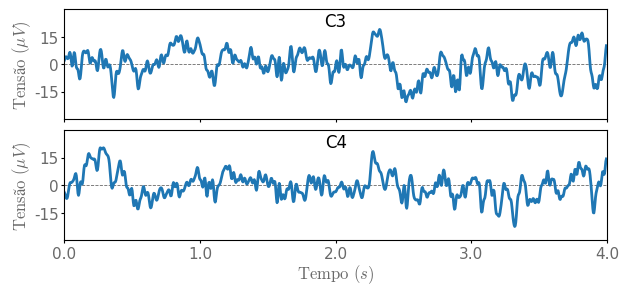

In [ ]:
plot_eeg_time(sample, Fs, ['C3', 'C4'])

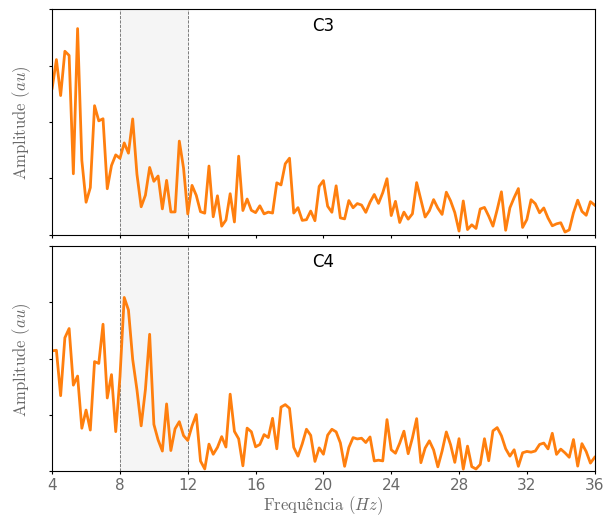

In [ ]:
plot_eeg_freq(sample, Fs, ['C3', 'C4'])

###**Janelamento e filtragem:** o primeiro passo é realizar o janelamento do sinal de EEG, de tal forma a simular a operação online. Uma vez janelado, cada segmento passa por um banco de filtros passa banda, considerando a banda alfa e beta sobretudo, para ressaltar o conteúdo espectral de interesse e rejeitar o conteúdo espectral fora da faixa.

In [ ]:
def segmenting(data, segment, step, Fs):
  N_samples, N_channels, N_classes, N_trials = data.shape
  N_seg, N_step = int(segment * Fs), int(step * Fs)
  steps = np.arange(0, N_samples - N_seg + 1, N_step)
  start_segs = np.rint(steps).astype(int)
  end_segs = (start_segs + N_seg).astype(int)
  N = len(start_segs)
  seg_data = np.zeros((N_seg, N_channels, N_classes, N * N_trials))
  c = 0
  for trial in range(N_trials):
    for n in range(N):
      seg_data[:, :, :, c] = data[start_segs[n]:end_segs[n], :, :, trial]
      c += 1
  return seg_data

In [ ]:
segment, step = 4, 4

In [ ]:
seg_data = segmenting(data[:, :, :, :, sub], segment, step, Fs)
seg_data.shape

(1000, 58, 2, 100)

In [ ]:
def filter_bank(f0, f1, fstep, df, gstop, Fs):
  fp = [(x, x + fstep) for x in np.arange(f0, f1 + df, fstep)]
  fs = [(x - df, x + fstep + df) for x in np.arange(f0, f1 + df, fstep)]
  wp, ws = np.array(fp) / (Fs / 2), np.array(fs) / (Fs / 2)
  gpass, gstop = 1, gstop
  sos = []
  freqz = []
  for i in range(wp.shape[0]):
    N, Wn = sig.cheb2ord(wp[i, :], ws[i, :], gpass, gstop)
    sos.append(sig.cheby2(N, gstop, Wn, 'bandpass', output='sos'))
    b, a = sig.cheby2(N, gstop, Wn, 'bandpass')
    freqz.append(sig.freqz(b, a))
  return sos, freqz

def plot_freq_resp(freqz, f0= 0, f1=40):
  x, y = np.arange(f0, f1 + 1, 4), np.arange(-40, 1, 10)
  xticks, yticks = x, y
  xlim, ylim = [f0, f1], [-45, 5]
  xlabel, ylabel = '$\\text{Frequência }(Hz)$', '$\\text{Amplitude }(dB)$'
  axcolor = 'dimgrey'
  plt.rcParams['font.size'] = 12
  plt.rcParams['mathtext.fontset'] = 'cm'
  fig = plt.figure(figsize=(7, 3))
  gs = fig.add_gridspec(1, 1)
  ax = gs.subplots()
  set_axis(x, y, xticks, yticks, ax, xlim, ylim)
  ax.set_xlabel(xlabel, color=axcolor, labelpad=1)
  ax.set_ylabel(ylabel, color=axcolor, labelpad=1)
  ax.grid(axis='both', color=axcolor, linestyle='--', linewidth=0.6)
  for w, h in freqz:
    ax.plot((Fs * w) / (2 * np.pi), 20 * np.log10(abs(h)), linewidth=2)

In [ ]:
f0, f1, fstep, df, gstop = 4, 32, 4, 1, 30
sos, freqz = filter_bank(f0, f1, fstep, df, gstop, Fs)

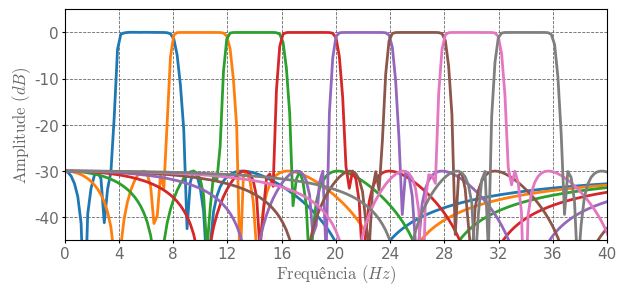

In [ ]:
plot_freq_resp(freqz)

In [ ]:
def filtering(data, sos):
  N = len(data.shape)
  f_count = 0
  fb_data = []
  for filt in sos:
    filt_data = sig.sosfiltfilt(filt, data, axis=0)
    exp_data = np.expand_dims(filt_data, N)
    fb_data = concat(fb_data, exp_data, N, f_count)
    f_count += 1
  return fb_data

In [ ]:
fb_data = filtering(seg_data, sos)
fb_data.shape

(1000, 58, 2, 100, 8)

In [ ]:
def plot_filtering(data, Fs, elect, f0=0, f1=40):
  N, Nf = data.shape[0], data.shape[-1]
  Ne = len(elect)
  f = np.arange(0, Fs, Fs / N)
  idx0 = np.where(f == f0)[0][0]
  idx1 = np.where(f == f1)[0][0] + 1
  fft_data = abs(fft(data, axis=0))[idx0:idx1,]
  A = np.max(fft_data) + 100
  x, y = np.arange(f0, f1 + 1, 4), [0, A / 4, A / 2, 3 * A / 4, A]
  xticks, yticks = x, []
  xlim, ylim = [f0, f1], [0, A]
  xlabel, ylabel = '$\\text{Frequência }(Hz)$', '$\\text{Amplitude }(au)$'
  axcolor = 'dimgrey'
  plt.rcParams['font.size'] = 12
  plt.rcParams['mathtext.fontset'] = 'cm'
  fig = plt.figure(figsize=(7, 3 * Ne))
  gs = fig.add_gridspec(2, 1, hspace=0.05)
  axs = gs.subplots()
  for n, ax in enumerate(axs):
    if n == 0:
      set_axis(x, y, [], yticks, ax, xlim, ylim)
    else:
      set_axis(x, y, xticks, yticks, ax, xlim, ylim)
      ax.set_xlabel(xlabel, color=axcolor, labelpad=1)
    ax.set_ylabel(ylabel, color=axcolor, labelpad=1)
    ax.grid(axis='both', color=axcolor, linestyle='--', linewidth=0.6)
    ax.plot(f[idx0:idx1], fft_data[:, n,], linewidth=2)
    ax.text(0.5, 0.92, elect[n], color='black', ha='center',
            va='center', transform=ax.transAxes)

In [ ]:
fb_sample = fb_data[:, ch_index, 0, 0, :]

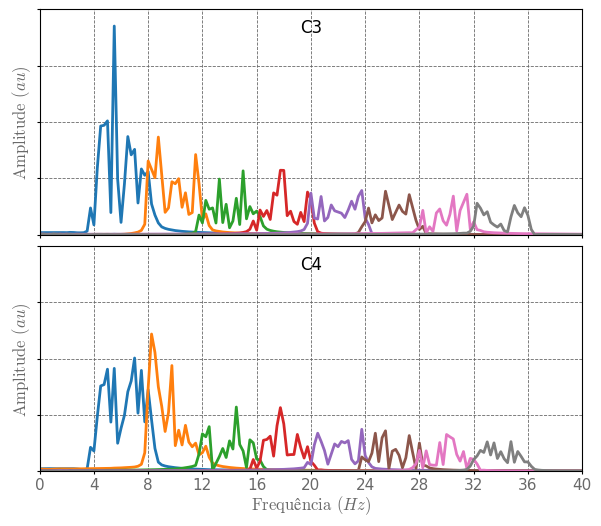

In [ ]:
plot_filtering(fb_sample, Fs, ['C3', 'C4'])

###**Extração de características:** uma vez filtrado, pode-se calcular o logaritmo da variância da saída do filtro, de cada segmento.

In [ ]:
def var_features(data):
  var_data = np.expand_dims(-np.log(np.var(data, axis=0)), 0)
  var_data = np.swapaxes(var_data, 0, -1)
  var_data = np.squeeze(var_data)
  return var_data

In [ ]:
var_data = var_features(fb_data)
var_data.shape

(8, 58, 2, 100)

In [ ]:
def plot_features(var_data, elect, f0, f1, fstep):
  fp = [(x, x + fstep) for x in range(f0, f1 + 1, fstep)]
  N = math.ceil(len(fp) / 2)
  xlabel = '$-\\log (\\text{var}' + '({}))$'.format(elect[0])
  ylabel = '$-\\log (\\text{var}' + '({}))$'.format(elect[1])
  axcolor = 'dimgrey'
  plt.rcParams['font.size'] = 11
  plt.rcParams['mathtext.fontset'] = 'cm'
  fig = plt.figure(figsize=(7, N * 3))
  gs = fig.add_gridspec(N, 2, hspace=0.055, wspace=0.05)
  axs = gs.subplots()
  for n, ax in enumerate(axs.flatten()):
    if n <= len(fp) - 1:
      x, y = set_ticks(var_data[n, 0,]), set_ticks(var_data[n, 1,])
      xticks, yticks = [], []
      xlim, ylim = [x[0], x[-1]], [y[0], y[-1]]
      set_axis(x, y, [], [], ax, xlim, ylim)
      if n % 2 == 0 and n != 2 * N - 2:
        ax.set_ylabel(ylabel, color=axcolor, labelpad=1)
      elif n == 2 * N - 2:
        ax.set_xlabel(xlabel, color=axcolor, labelpad=1)
        ax.set_ylabel(ylabel, color=axcolor, labelpad=1)
      elif n == 2 * N - 1:
        ax.set_xlabel(xlabel, color=axcolor, labelpad=1)
      ax.scatter(var_data[n, 0, 0,], var_data[n, 1, 0,], s=30,
                 color='tab:blue', edgecolors='black',
                 linewidths=0.5, label='esquerda')
      ax.scatter(var_data[n, 0, 1,], var_data[n, 1, 1,], s=30,
                 color='tab:orange', edgecolors='black',
                 linewidths=0.5, label='direita')
      ax.text(0.04, 0.92, '{}-{} Hz'.format(*fp[n]), color='black',
              ha='left', va='center', transform=ax.transAxes)
    else:
      ax.remove()
      ax = axs.flatten()[n - 1]
  ax.legend(loc='lower right', fontsize=11)

def set_ticks(data):
  mean, std = np.mean(data), np.std(data)
  Amax, Amin = mean + 3.0 * std, mean - 3.0 * std
  A = (Amax - Amin) / 4
  return np.arange(Amin, Amax + A, A)

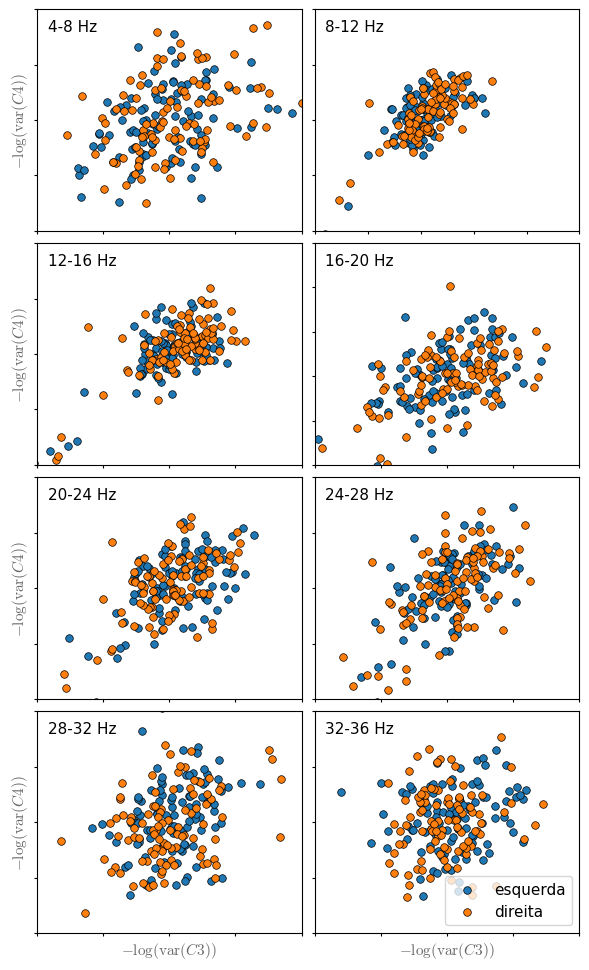

In [ ]:
plot_features(var_data[:, ch_index,], ['C3', 'C4'], f0, f1, fstep)

##**2.3 Dados multivariados**

###**Matriz de dados:** Nas aplicações de BCI, as amostras de entrada de um canal de EEG representam observações no tempo, e considerando vários canais/observações no tempo/espaço, temos uma matriz de observações. Logo, o conjunto amostral de entrada é representado por uma matriz de dados:

###\begin{align}
  \mathbf{X} =
  \begin{bmatrix}
    x_1^1 & x_1^2 & \cdots & x_1^N \\
    x_2^1 & x_2^2 & \cdots & x_2^N \\
    \vdots \\
    x_d^1 & x_d^2 & \cdots & x_d^N
  \end{bmatrix} \qquad(2.1)
\end{align}

###em que as $d$ linhas correspondem às $d$ variáveis de entrada, associadas aos canais de EEG, e a $N$ colunas correspondem às $N$ amostras/observações.

###**Variáveis correlacionadas:** Considerando uma matriz de dados $\mathbf{X}$, os canais de EEG (linhas) podem ser correlacionados entre si. Lembre-se que, a partir de $\mathbf{X}$, podemos fazer uma análise exploratória dos dados, para formular uma hipótese explicativa, ou podemos fazer uma análise preditiva, no qual estamos interessados em propor um regressor ou um classificador para predizer amostras novas.

###**Vetor de médias:** Dada uma matriz de dados, $\mathbf{X}$, o vetor de médias $\boldsymbol{\mu}$ é definido como a média das $N$ observações em cada linha $d$:

###\begin{align}
  E[\mathbf{X}] = \boldsymbol{\mu}=
  \begin{bmatrix}
    \mu_1 \\
    \mu_2 \\
    \vdots \\
    \mu_d
  \end{bmatrix} \qquad(2.2)
\end{align}

em que $ \mu_i = E[X_i]$.

###**Variância e covariância:** A Variância de $X_i$ é dada por $\sigma_i^2 = E[(X_i-\mu_i)^2]$, e a covariância entre duas variáveis aleatórias $X_i$ e $X_j$ é dada por:

###\begin{align}
  \sigma_{ij} \equiv \text{cov}(X_i,X_j) = E[(X_i- \mu_i)(X_j- \mu_j)] \qquad(2.3)
\end{align}

###com $\sigma_{ij}=\sigma_{ji}$ e, quando $i=j$, $\sigma_{ii}=\sigma_i^2$.

###**Matriz de covariâncias:** Com $d$ variáveis (canais), há $d$ variâncias e $d(d-1)/2$ covariâncias, que podem ser arranjadas em uma matriz $d\times d$, denominada matriz de covariâncias, $\boldsymbol{\Sigma}$, com elementos $\sigma_{ij}$:

###\begin{align}
  \boldsymbol{\Sigma} =
  \begin{bmatrix}
    \sigma_1^2 & \sigma_{12} & \cdots & \sigma_{1d} \\
    \sigma_{21} & \sigma_2^2 & \cdots & \sigma_{2d} \\
    \vdots \\
    \sigma_{d1} & \sigma_{d2} & \cdots & \sigma_d^2
  \end{bmatrix} \qquad(2.4)
\end{align}

###em que os termos da diagonal principal são as variâncias e os elementos fora da diagonal principal são as covariâncias. Note que a matriz é simétrica.

###**Matriz de covariância em notação vetorial:** Podemos representar a matriz de covariância em uma notação compacta, utilizando notação vetorial:

###\begin{align}
  \boldsymbol{\Sigma} \equiv \text{cov}(\mathbf{X}) = E[(\mathbf{X}- \boldsymbol{\mu})(\mathbf{X}- \boldsymbol{\mu})^\mathsf{T}] \qquad(2.5)
\end{align}

###**Estimação de parâmetros:** Dado um conjunto amostral multivariado, podemos estimar os parâmetros por máxima verossimilhança. A estimativa da média é a média amostral, portanto a estimativa do vetor de médias é:

###\begin{align}
  \mathbf{m} = \frac{1}{N} \sum_{t=1}^N \mathbf{x}^t =
  \begin{bmatrix}
    m_1 \\
    m_2 \\
    \vdots \\
    m_d
  \end{bmatrix} \qquad(2.6)
\end{align}

###em que

###\begin{align}
  m_i = \frac{1}{N} \sum_{t=1}^N x_i^t \ , \ i=1, 2, \dots, d \qquad(2.7)
\end{align}

###enquanto a estimativa da variância e da covariância são, respectivamente, a variância amostral e a covariância amostral:

###\begin{align}
  s_i^2 &= \frac{1}{N} \sum_{t=1}^N (x_i^t - m_i)^2 \\
  s_{ij} &= \frac{1}{N} \sum_{t=1}^N (x_i^t - m_i)(x_j^t - m_j) \qquad(2.8)
\end{align}

###que, por sua vez, definem a estimativa da matriz de covariância, $\mathbf{S}$:

###\begin{align}
  \mathbf{S} =
  \begin{bmatrix}
    s_1^2 & s_{12} & \cdots & s_{1d} \\
    s_{21} & s_2^2 & \cdots & s_{2d} \\
    \vdots \\
    s_{d1} & s_{d2} & \cdots & s_d^2
  \end{bmatrix} \qquad(2.9)
\end{align}

##**2.4 Transformação linear**

###**Transformação linear:** Quando uma matriz(ou vetor) de dados $\mathbf{X}$ é transformada linearmente para outra matriz/vetor $\mathbf{Y}$, $\mathbf{Y}$ é expresso como uma combinação linear de $\mathbf{X}$:

###\begin{align}
  \mathbf{Y} = \mathbf{W}^{\mathsf{T}}\mathbf{X} \qquad(2.10)
\end{align}

###em que $\mathbf{W}$ representa uma matriz/vetor de coeficientes da transformação. Dizemos que é linear porque vale a propriedade da superposição, de tal forma que não altera a distribuição de entrada.

###**Vetor de médias e matriz de covariâncias:** como se trata de uma combinação linear, o vetor de médias e a matriz de covariância de $\mathbf{Y}$ podem ser expressos a partir do vetor  médias e da matriz de covariâncias de $\mathbf{X}$, ou seja:

###\begin{align}
  \boldsymbol{\mu}_Y=E[\mathbf{Y}] &= E[\mathbf{W}^{\mathsf{T}}\mathbf{X}] \\
  &= \mathbf{W}^{\mathsf{T}}E[\mathbf{X}] \\
  &=\mathbf{W}^{\mathsf{T}}\boldsymbol{\mu}_X \qquad(2.11)
\end{align}

###e

###\begin{align}
  \boldsymbol{\Sigma}_Y &= E[(\mathbf{Y}- \boldsymbol{\mu}_Y)(\mathbf{Y}- \boldsymbol{\mu}_Y)^\mathsf{T}] \\
  &= E[\mathbf{W}^{\mathsf{T}}(\mathbf{X}- \boldsymbol{\mu}_X)(\mathbf{W}^{\mathsf{T}}(\mathbf{X}- \boldsymbol{\mu}_X))^\mathsf{T}] \\
  &= \mathbf{W}^{\mathsf{T}}E[(\mathbf{X}- \boldsymbol{\mu}_X)(\mathbf{X}- \boldsymbol{\mu}_X)^\mathsf{T}]\mathbf{W} \\
  &= \mathbf{W}^{\mathsf{T}}\boldsymbol{\Sigma}_X\mathbf{W} \qquad(2.12)
\end{align}

###em que a regra matricial $(AB)^\mathsf{T}=B^\mathsf{T}A^\mathsf{T}$ foi utilizada na segunda demonstração

##**2.5 Padrão espacial comum**

###**Padrão espacial comum (CSP, do inglês common spatial pattern):** é uma transformação linear (filtro) que maximiza a variância de uma distribuição (associada com uma classe do problema) enquanto minimiza a variância da outra distribuição (associada com outra classe do problema).

###**Função custo:** considerando $\mathbf{m}_1=\mathbf{m}_2=0$, o CSP é um filtro espacial que busca maximizar a seguinte função custo:

###\begin{align}
  J(\mathbf{W}) = \frac{\mathbf{W}^{\mathsf{T}}E[\mathbf{X}_1\mathbf{X}_1^\mathsf{T}]\mathbf{W}}{\mathbf{W}^{\mathsf{T}}E[\mathbf{X}_2\mathbf{X}_2^\mathsf{T}]\mathbf{W}} \cong \frac{\mathbf{W}^{\mathsf{T}}\mathbf{S}_1\mathbf{W}}{\mathbf{W}^{\mathsf{T}}\mathbf{S}_2\mathbf{W}} \qquad(2.13)
\end{align}

###em que $\mathbf{S}_1$ é matriz de covariância amostral de uma classe, $\mathbf{S}_2$ é matriz de covariância amostral da outra classe e $\mathbf{W}$ são os coeficientes do filtro.

###**Problema de otimização:** observando que $J(\mathbf{W})$ permanece inalterado se os coeficientes $\mathbf{W}$ forem escalados, ou seja, $J(k\mathbf{W}) = J(\mathbf{W})$ para efeitos de otimização, podemos maximizar $\mathbf{W}^{\mathsf{T}}\mathbf{S}_1\mathbf{W}$ sujeito a $\mathbf{W}^{\mathsf{T}}\mathbf{S}_2\mathbf{W}=1$, dado que sempre é possível achar um $k$ que satisfaça $\mathbf{W}^{\mathsf{T}}\mathbf{S}_2\mathbf{W}=1$.

###**Optimização com restrições:** esse tipo de problema é conhecido como otimização com restrições, no qual empregamos o método de Lagrange para resolvê-lo. A equação de Lagrange do referido problema é:

###\begin{align}
  L(\mathbf{W}) = \mathbf{W}^{\mathsf{T}}\mathbf{S}_1\mathbf{W} - \lambda(\mathbf{W}^{\mathsf{T}}\mathbf{S}_2\mathbf{W} - 1) \qquad(2.14)
\end{align}

###**Derivação:** para achar os coeficientes ótimos, basta derivar essa expressão e igualá-la a zero

###\begin{align}
  \frac{\partial L}{\partial \mathbf{W}} = 2\mathbf{S}_1\mathbf{W} - 2\lambda\mathbf{S}_2\mathbf{W} = 0 \qquad(2.15)
\end{align}

###**Problema de autovalores e autovetores:** ao rearranjar a **Equação 2.15**, obtemos:

###\begin{align}
  \mathbf{S}_1\mathbf{W} &= \lambda\mathbf{S}_2\mathbf{W} \\
  \mathbf{S}_2^{-1}\mathbf{S}_1\mathbf{W} &= \lambda\mathbf{W} \\
  (\mathbf{S}_2^{-1}\mathbf{S}_1 - \lambda\mathbf{I})\cdot\mathbf{W} &= \mathbf{0} \qquad(2.16)
\end{align}

###que é a formulação padrão de um problema de autovalores e autovetores. Para isso, basta resolver a equação característica:

###\begin{align}
  \det |\ \mathbf{S}_2^{-1}\mathbf{S}_1 - \lambda\mathbf{I} |\ = \mathbf{0}\qquad(2.17)
\end{align}

###e achar todos os coeficientes $\lambda$, autovalores, que satisfazem a **Equação 2.17**. A partir dos coeficientes $\lambda$ podemos achar todos os autovetores, $\mathbf{W}$, do problema, que são os pesos do nosso filtro.

###**Direção de maior variância e menor variância:** os autovalores/autovetores da transformação linear representam uma mudança de base do sinal original em $\mathbf{X}$ para o sinal mapeado em $\mathbf{Y}$. O maior autovalor corresponde à direção/autovetor de maior variância do sinal, o segundo maior à segunda direção de maior variância, e assim sucessivamente, até o menor autovalor que representa a direção de menor variação do sinal.

###**Diagonalização simultânea:** estamos interessados em diferenciar ao máximo as duas distribuições. Portanto, usamos como filtro espacial exatamente o autovetor de máxima variância e o autovetor de mínima variância para ser os coeficientes do filtro espacial comum. O efeito disso é realizar a diagonalização simultânea das duas distribuições, de tal forma que a direção de máxima variação da distribuição de $\mathbf{S}_1$ seja perpendicular a direção de máxima variação de $\mathbf{S}_2$, e vice-versa.

##**2.6 Extração de SMR com CSP**

###**Matriz de covariância:** uma vez filtrado, é calculado a matriz de covariância de cada janela e computada a média das matrizes de covariância dentro de cada classe. Ou seja, é computado $\mathbf{S}_1$ e $\mathbf{S}_2$. Como usamos os rótulos de problema para saber qual é a distribuição de classes, precisamos projetar o filtro apenas com os dados de treinamento, separando um conjunto de dados para teste.

###**Filtro espacial:** os valores obtidos de $\mathbf{S}_1$ e $\mathbf{S}_2$ são utilizados para achar os autovalores/autovetores do problema de otimização mostrado anteriormente. Os autovalores máximo e mínimo são os autovetores que representam os coeficientes do filtro. Cada janela de EEG é então filtrada espacialmente.

In [ ]:
def csp_training(data):
  W = []
  for filt in range(data.shape[-1]):
    S1 = cov_matrix(data[:, :, 0, :, filt])
    S2 = cov_matrix(data[:, :, 1, :, filt])
    W.append(csp(S1, S2))
  return W

def cov_matrix(data):
  N = len(data.shape)
  cov_data = []
  for i in range(data.shape[-1]):
    cov = np.cov(np.matrix.transpose(data[:, :, i]))
    exp_cov = np.expand_dims(cov, N - 1)
    cov_data = concat(cov_data, exp_cov, N - 1, i)
  return np.mean(cov_data, axis=N-1)

def csp(S1, S2):
  S2_inv = np.linalg.pinv(S2)
  eigenvalues, eigenvectors = np.linalg.eig(np.matmul(S2_inv, S1))
  index = np.argsort(eigenvalues)[::-1]
  W = eigenvectors[:, [index[0], index[-1]]]
  return W

def csp_filtering(data, W):
  N_samples, _, N_classes, N_trials, N_filters = data.shape
  N = len(data.shape)
  csp_data = np.zeros((N_samples, 2, N_classes, N_trials, N_filters))
  for k in range(N_filters):
    for j in range(N_trials):
      for i in range(N_classes):
        csp_data[:, :, i, j, k] = np.matmul(data[:, :, i, j, k], W[k])
  return csp_data

def csp_cross_validation(data):
  N_samples, _, N_classes, N_trials, N_filters = data.shape
  csp_data = np.zeros((N_samples, 2, N_classes, N_trials, N_filters))
  trials = range(N_trials)
  kf = KFold(n_splits=5, shuffle=True, random_state=0)
  for n, (train_index, test_index) in enumerate(kf.split(trials)):
    train_data = data[:, :, :, train_index,]
    test_data = data[:, :, :, test_index,]
    W = csp_training(train_data)
    csp_data[:, :, :, test_index] = csp_filtering(test_data, W)
  return csp_data


In [ ]:
csp_data = csp_cross_validation(fb_data)
csp_data.shape

(1000, 2, 2, 100, 8)

In [ ]:
var_csp_data = var_features(csp_data)
var_csp_data.shape

(8, 2, 2, 100)

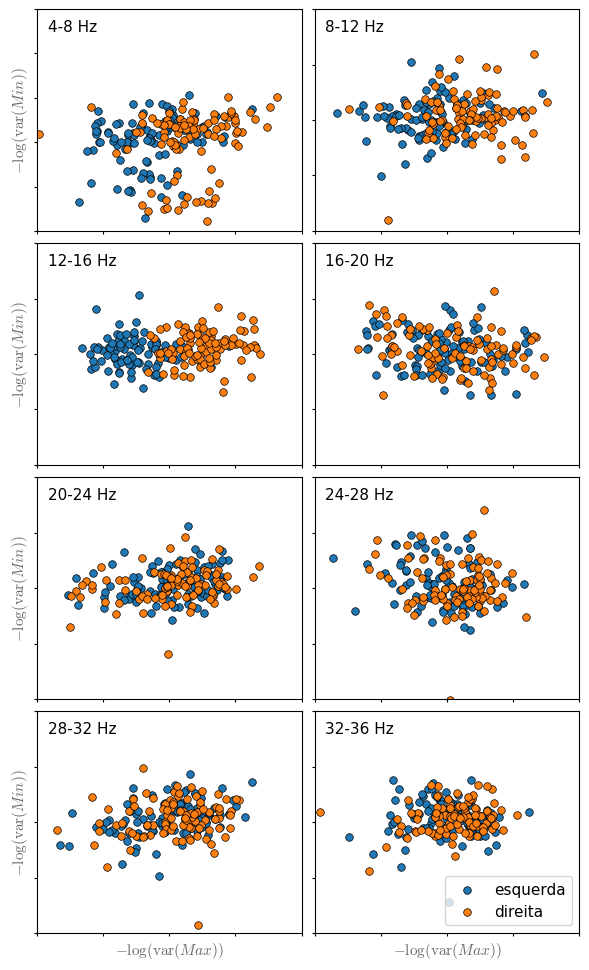

In [ ]:
plot_features(var_csp_data, ['Max', 'Min'], f0, f1, fstep)

##**2.7 Classificação de SMR**

###**Classificação:** podemos (por exemplo) usar um classificador linear para traçar uma fronteira de decisão entre as duas classes. Se for um problema de mais de duas classes, podemos resolvê-lo considerando classificadores binários. Nesse caso, cada classificador terá seu filtro espacial correspondente, e por isso uma sequência de extração própria.  A despeito disso, sempre decidimos pela classe cujo valor de classificação seja máximo.

In [ ]:
def classic_experiment(data, Fs, sos):
  segment, step = 4, 4
  N_folders = 5
  N_trials, N_subjects = data.shape[-2], data.shape[-1]
  kf = KFold(n_splits=N_folders, shuffle=True, random_state=0)
  s_score = []
  for sub in range(N_subjects):
    score = []
    trials = range(N_trials)
    for n, (train_index, test_index) in enumerate(kf.split(trials)):
      # train
      train_data = data[:, :, :, train_index, sub]
      seg_data = segmenting(train_data, segment, step, Fs)
      fb_data = filtering(seg_data, sos)
      W = csp_training(fb_data)
      X, y = feature_extraction(fb_data, W)
      model = svm.SVC().fit(X, y)
      # test
      test_data = data[:, :, :, test_index, sub]
      seg_data = segmenting(test_data, segment, step, Fs)
      fb_data = filtering(seg_data, sos)
      X, y = feature_extraction(fb_data, W)
      score.append(model.score(X, y))
    s_score.append(score)
  s = ['s{}'.format(n) for n in range(N_subjects)]
  p = ['p{}'.format(n) for n in range(N_folders)]
  results = pd.DataFrame(s_score, s, p)
  results['m'] = results.mean(axis=1)
  results['d.p.'] = results.std(axis=1)
  return results.round(2)

def feature_extraction(data, W):
  csp_data = csp_filtering(data, W)
  var_data = var_features(csp_data)
  X, y = attribute_matrix(var_data)
  return X, y

def attribute_matrix(features):
  labels = []
  feature_matrix = []
  for k in range(features.shape[-1]):
    v_features = []
    for j in range(features.shape[-2]):
      labels = np.hstack((labels, j))
      h_features = []
      for i in range(features.shape[-3]):
        h_features = concat(h_features, features[:, i, j, k], 0, i)
      feature_vector = np.transpose(np.expand_dims(h_features, axis=1))
      v_features = concat(v_features, feature_vector, 0, j)
    feature_matrix = concat(feature_matrix, v_features, 0, k)
  X, y = shuffle(feature_matrix, labels, random_state=0)
  return X, y

In [ ]:
classic_experiment(data, Fs, sos)

,p0,p1,p2,p3,p4,m,d.p.
s0,0.82,0.68,0.60,0.68,0.75,0.70,0.08
s1,0.55,0.55,0.55,0.45,0.52,0.52,0.04
s2,0.60,0.78,0.65,0.78,0.65,0.69,0.07
s3,0.55,0.50,0.45,0.48,0.52,0.50,0.04
s4,0.90,0.85,0.82,0.90,0.95,0.88,0.04
s5,0.90,0.90,0.80,0.90,0.88,0.88,0.04
s6,0.57,0.62,0.60,0.48,0.52,0.56,0.05
s7,0.42,0.60,0.48,0.48,0.52,0.50,0.06
s8,0.40,0.60,0.50,0.55,0.50,0.51,0.07
s9,0.42,0.52,0.55,0.52,0.52,0.51,0.04


### **EEGNet ([10.1088/1741-2552/aace8c](https://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta))**: *EEGNet: a compact convolutional neural network for EEG-based brain–computer interfaces*

In [ ]:
def deep_experiment(data, Fs):
  segment, step = 4, 4
  N_folders = 5
  N_trials, N_subjects = data.shape[-2], data.shape[-1]
  kf = KFold(n_splits=N_folders, shuffle=True, random_state=0)
  s_score = []
  for sub in range(N_subjects):
    score = []
    trials = range(N_trials)
    for n, (train_index, test_index) in enumerate(kf.split(trials)):
      # train
      train_data = data[:, :, :, train_index, sub]
      seg_data = segmenting(train_data, segment, step, Fs)
      X, y = attribute_tensor(seg_data)
      y = to_categorical(y, num_classes=len(set(y)))
      model = train_eegnet(X, y)
      # test
      test_data = data[:, :, :, test_index, sub]
      seg_data = segmenting(test_data, segment, step, Fs)
      X, y = attribute_tensor(seg_data)
      y = to_categorical(y, num_classes=len(set(y)))
      score.append(model.evaluate(X, y, verbose=0)[1])
    s_score.append(score)
  s = ['s{}'.format(n) for n in range(N_subjects)]
  p = ['p{}'.format(n) for n in range(N_folders)]
  results = pd.DataFrame(s_score, s, p)
  results['m'] = results.mean(axis=1)
  results['d.p.'] = results.std(axis=1)
  return results.round(2)

def attribute_tensor(data):
  N = len(data.shape)
  if N == 4:
    data = np.expand_dims(data, N)
  data = np.swapaxes(np.swapaxes(np.swapaxes(data, 0, 2), 0, -2), -1, -2)
  N_trials = data.shape[0]
  labels = []
  feature_tensor = []
  for n in range(data.shape[-1]):
    labels = np.hstack((labels, N_trials * [n]))
    feature_tensor = concat(feature_tensor, data[:, :, :, :, n], 0, n)
  X, y = shuffle(feature_tensor, labels, random_state=0)
  return X, y

def train_eegnet(X, y):
  _, N_channels, N_samples, N_filters = X.shape
  N_classes = y.shape[1]
  model = eegnet(N_channels, N_samples, N_filters, 8, 2, N_classes)
  model.fit(X, y, epochs=100, batch_size=32, verbose=0)
  return model

def eegnet(C, T, F0, F1, D, N):
  F2 = D * F1
  model = Sequential()
  model.add(Input(shape=(C, T, F0)))
  # block 1
  model.add(Conv2D(F1, (1, 64) , activation = 'linear',
                   padding = 'same', use_bias = False))
  model.add(BatchNormalization(axis = 1))
  model.add(DepthwiseConv2D((C, 1), activation = 'linear',
                            use_bias = False, depth_multiplier = D,
                            depthwise_constraint = max_norm(1.)))
  model.add(BatchNormalization(axis = 1))
  model.add(Activation('elu'))
  model.add(AveragePooling2D((1, 4)))
  model.add(Dropout(0.5))
  # block 2
  model.add(SeparableConv2D(F2, (1, 16), activation = 'linear',
                            padding = 'same', use_bias = False,))
  model.add(BatchNormalization(axis = 1))
  model.add(Activation('elu'))
  model.add(AveragePooling2D((1, 8)))
  model.add(Dropout(0.5))
  # classifier
  model.add(Flatten(name = 'flatten'))
  model.add(Dense(N, name = 'dense', activation = 'softmax',
                  kernel_constraint = max_norm(0.25)))
  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                metrics = ['accuracy'])
  return model

In [ ]:
deep_experiment(data, Fs)

,p0,p1,p2,p3,p4,m,d.p.
s0,0.90,0.82,0.82,0.85,0.93,0.86,0.04
s1,0.60,0.38,0.65,0.57,0.60,0.56,0.10
s2,0.90,0.90,1.00,0.98,0.93,0.94,0.04
s3,0.60,0.55,0.62,0.55,0.55,0.58,0.03
s4,0.90,0.98,0.98,0.90,0.95,0.94,0.03
s5,0.93,0.98,0.98,0.98,1.00,0.97,0.02
s6,0.85,0.75,0.82,0.88,0.80,0.82,0.04
s7,0.93,0.95,0.88,0.85,0.98,0.92,0.05
s8,0.77,0.80,0.77,0.70,0.80,0.77,0.04
s9,0.88,0.95,1.00,0.88,0.90,0.92,0.05


##**Referências**

###FUKUNAGA, Keinosuke. Introduction to statistical pattern recognition. Elsevier, 2013.

###PFURTSCHELLER, Gert; NEUPER, Christa. Motor imagery and direct brain-computer communication. "Proceedings of the IEEE", v. 89, n. 7, p. 1123-1134, 2001.

### YANG, Banghua et al. A multi-day and high-quality EEG dataset for motor imagery brain-computer interface. Scientific Data, v. 12, n. 1, p. 488, 2025.

### ANG, Kai Keng et al. Filter bank common spatial pattern (FBCSP) in brain-computer interface. In: 2008 IEEE international joint conference on neural networks (IEEE world congress on computational intelligence). IEEE, 2008. p. 2390-2397.

### LAWHERN, Vernon J. et al. EEGNet: a compact convolutional neural network for EEG-based brain–computer interfaces. Journal of neural engineering, v. 15, n. 5, p. 056013, 2018.